In [ ]:
import numpy as np
import pandas as pd
import geopandas as gpd
import pyproj
import datetime
from shapely.geometry import Point

In [ ]:
data = pd.read_csv('uber_triprecords_apr14_sep14.csv')

In [ ]:
data.head(3)

In [ ]:
ctracts = gpd.GeoDataFrame.from_file('nyct2010.shp')

In [ ]:
def to_longlat(xy):
    state_plane = pyproj.Proj(init='EPSG:2263', preserve_units=True)
    wgs = pyproj.Proj(proj='latlong', datum='WGS84', ellps='WGS84')
    lng, lat = pyproj.transform(state_plane, wgs, xy[0], xy[1])
    return (lng, lat)

def to_xy(lnglat):
    wgs = pyproj.Proj(proj='latlong', datum='WGS84', ellps='WGS84')
    state_plane = pyproj.Proj(init='EPSG:2263', preserve_units=True)
    x, y = pyproj.transform(wgs, state_plane, lnglat[0], lnglat[1])
    return (x, y)

In [ ]:
data['xy'] = zip(data['Pickup Lng'], data['Pickup Lat'])

In [ ]:
data['xy'] = data['xy'].apply(lambda xy: to_xy(xy))

In [ ]:
data = data[[data.columns[0], data.columns[-1]]]

In [ ]:
Geometry = [Point(xy) for xy in data['xy']]

In [ ]:
geodata = gpd.GeoDataFrame(data, crs = {'init': 'EPSG:2263'}, geometry = Geometry)

In [ ]:
data = []

In [ ]:
geodata = geodata[[geodata.columns[0], geodata.columns[-1]]]

In [ ]:
ctracts = ctracts[[ctracts.columns[0], ctracts.columns[-1]]]

In [ ]:
ctracts.crs = {'init': 'EPSG:2263'}

In [ ]:
geodata_ctracts = gpd.tools.sjoin(geodata, ctracts, how = 'right', op = 'intersects')

In [ ]:
geodata_ctracts = geodata_ctracts[['Pickup Date/Time', 'BoroCT2010']]

In [ ]:
geodata_ctracts.head(3)

In [ ]:
geodata = []

In [ ]:
geodata_ctracts = geodata_ctracts.dropna()

In [ ]:
def is_sunday(datetime_):
    month, day, year = datetime_.split(' ')[0].split('/')
    return datetime.datetime(int(year), int(month), int(day)).weekday() == 6

def get_minutes(datetime_):
    hour, minute = datetime_.split(' ')[1].split(':')
    return int(hour)*60 + int(minute)

In [ ]:
geodata_ctracts['minutes'] = geodata_ctracts['Pickup Date/Time'].apply(lambda x: get_minutes(x))

In [ ]:
sundays = geodata_ctracts[geodata_ctracts['Pickup Date/Time'].apply(lambda x: is_sunday(x))]
weekdays = geodata_ctracts[geodata_ctracts['Pickup Date/Time'].apply(lambda x: not is_sunday(x))]

In [ ]:
sundays.head(2), weekdays.head(2)

In [ ]:
geodata_ctracts = []

In [ ]:
months = ['4_april', '5_may', '6_june', '7_july', '8_august', '9_september']

def what_month(datetime_):
    return int(datetime_.split(' ')[0].split('/')[0])

def get_monthly_data(dataframe_, month):
    return dataframe_[dataframe_['Pickup Date/Time'].apply(lambda x: what_month(x) == month)]

In [ ]:
sundays_monthly = map(get_monthly_data, [sundays]*len(months), map(lambda m: int(m[0]), months))
weekdays_monthly = map(get_monthly_data, [weekdays]*len(months), map(lambda m: int(m[0]), months))

In [ ]:
sundays = []
weekdays = []

In [ ]:
def time_to_minutes(time):
    hours = int(time[:2])
    minutes = int(time[2:])
    return hours*60+minutes

In [ ]:
# Weekdays
weekday_periods = [[time_to_minutes('0000'), time_to_minutes('0600')],
                   [time_to_minutes('0600'), time_to_minutes('1000')],
                   [time_to_minutes('1000'), time_to_minutes('1530')],
                   [time_to_minutes('1530'), time_to_minutes('1630')],
                   [time_to_minutes('1630'), time_to_minutes('1800')],
                   [time_to_minutes('1800'), time_to_minutes('2100')],
                   [time_to_minutes('2100'), time_to_minutes('2400')]]

# Sundays
sunday_periods = [[time_to_minutes('0000'), time_to_minutes('0200')],
                  [time_to_minutes('0200'), time_to_minutes('1400')],
                  [time_to_minutes('1400'), time_to_minutes('1600')],
                  [time_to_minutes('1600'), time_to_minutes('2400')]]

In [ ]:
def split_to_periods(dataframe_, periods):
    return map(lambda period: dataframe_[dataframe_['minutes'].apply(lambda x: x>= period[0] and x < period[1])],
                periods)

In [ ]:
sundays_monthly = map(split_to_periods, sundays_monthly, [sunday_periods]*len(sundays_monthly))

In [ ]:
weekdays_monthly = map(split_to_periods, weekdays_monthly, [weekday_periods]*len(weekdays_monthly))

In [ ]:
def group_by_tract(dataframe_, month):
    grouped = dataframe_.groupby(['BoroCT2010']).count()
    grouped = grouped.reset_index()
    grouped = grouped[['BoroCT2010', 'minutes']]
    grouped.columns = [['BoroCT2010', str(month)+'_uber']]
    return grouped

In [ ]:
sundays_monthly = map(lambda month: map(lambda period: group_by_tract(sundays_monthly[month][period], 
                             months[month]), range(len(sundays_monthly[month]))), range(len(sundays_monthly)))

weekdays_monthly = map(lambda month: map(lambda period: group_by_tract(weekdays_monthly[month][period], 
                             months[month]), range(len(weekdays_monthly[month]))), range(len(weekdays_monthly)))

In [ ]:
def merge_months(dataframe_, period):
    result = dataframe_[0][period]
    for i in range(1, len(dataframe_)):
        result = result.merge(dataframe_[i][period], how = 'outer')
    result = result.fillna(value = 0)
    return result
    #return reduce(lambda x, y: x.merge(), dataframe_)

In [ ]:
sundays_aggregated = map(lambda period: merge_months(sundays_monthly, period), range(len(sunday_periods)))
weekdays_aggregated = map(lambda period: merge_months(weekdays_monthly, period), range(len(weekday_periods)))

In [ ]:
weekday_names = ['weekday_1200amto0600am', 'weekday_0600amto1000am', 'weekday_1000amto0330pm',
                 'weekday_0330pmto0430pm', 'weekday_0430pmto0600pm', 'weekday_0600pmto0900pm',
                 'weekday_0900pmto1200am']
sunday_names =  ['sunday_1200amto0200am', 'sunday_0200amto0200pm', 'sunday_0200pmto0400pm', 
                 'sunday_0400pmto1200am']

In [ ]:
def linear_fit(df):
    cols = df.columns[1:]
    df['reg_apr-sept_uber'] = zip(df[cols[0]], df[cols[1]], df[cols[2]], df[cols[3]], df[cols[4]], df[cols[5]])
    df['reg_apr-sept_uber'] = df['reg_apr-sept_uber'].apply(lambda x: np.polyfit(range(6), x, 1))
    df['reg_may-sept_uber'] = zip(df[cols[1]], df[cols[2]], df[cols[3]], df[cols[4]], df[cols[5]])
    df['reg_may-sept_uber'] = df['reg_may-sept_uber'].apply(lambda x: np.polyfit(range(5), x, 1))
    #return df
    return df

In [ ]:
sundays_aggregated = map(linear_fit, sundays_aggregated)

In [ ]:
weekdays_aggregated = map(linear_fit, weekdays_aggregated)

In [ ]:
saves = map(lambda x: weekdays_aggregated[x].to_csv('uber_'+weekday_names[x]+'.csv'), range(len(weekday_names)))

In [ ]:
saves = map(lambda x: sundays_aggregated[x].to_csv('uber_'+sunday_names[x]+'.csv'), range(len(sunday_names)))

# Plotting

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import pyproj
import datetime
from shapely.geometry import Point
pd.set_option('display.max_rows', 2300)
from geopandas import GeoDataFrame
import pylab as pl
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib

In [2]:
name_week = ['weekday_1200amto0600am.csv', 'weekday_0600amto1000am.csv', 'weekday_1000amto0330pm.csv',
        'weekday_0330pmto0430pm.csv', 'weekday_0430pmto0600pm.csv', 'weekday_0600pmto0900pm.csv',
        'weekday_0900pmto1200am.csv']
name_sund = ['sunday_1200amto0200am.csv', 'sunday_0200amto0200pm.csv', 
        'sunday_0200pmto0400pm.csv', 'sunday_0400pmto1200am.csv']

In [3]:
yellow_week = map(lambda name: pd.read_csv(name, usecols=['CT', 'reg_april-september']), name_week)
yellow_sund = map(lambda name: pd.read_csv(name, usecols=['CT', 'reg_april-september']), name_sund)
uber_week = map(lambda name: pd.read_csv('uber_'+name, usecols=['BoroCT2010', 'reg_apr-sept_uber']), name_week)
uber_sund = map(lambda name: pd.read_csv('uber_'+name, usecols=['BoroCT2010', 'reg_apr-sept_uber']), name_sund)

In [4]:
yellow_week = map(lambda period: period.rename(index=str, 
                    columns={"CT": "BoroCT2010", "reg_april-september": "yellowGreen"}), yellow_week)
yellow_sund = map(lambda period: period.rename(index=str, 
                    columns={"CT": "BoroCT2010", "reg_april-september": "yellowGreen"}), yellow_sund)

uber_week = map(lambda period: period.rename(index=str, 
                    columns={"reg_apr-sept_uber": "uber"}), uber_week)
uber_sund = map(lambda period: period.rename(index=str, 
                    columns={"reg_apr-sept_uber": "uber"}), uber_sund)

In [5]:
yellow_week[0].head(1), uber_week[0].head(1)

(   BoroCT2010                yellowGreen
 0     3026600  [-0.91428571  7.95238095],
    BoroCT2010                       uber
 0     1000201  [ 1.6         5.66666667])

In [6]:
ctracts = gpd.GeoDataFrame.from_file('nyct2010.shp')
ctracts = ctracts[['BoroCT2010', 'geometry']]
ctracts.head(3)

BoroCT2010                                           geometry
0    5000900  POLYGON ((962269.1260375977 173705.5001831055,...
1    1009800  POLYGON ((994133.507019043 214848.8975830078, ...
2    1010000  POLYGON ((993108.3057861328 216013.1307983398,...

In [7]:
def ct_to_int(dataframe_):
    dataframe_['BoroCT2010'] = dataframe_['BoroCT2010'].apply(lambda x: int(x))
    return dataframe_

uber_week = map(ct_to_int, uber_week)
uber_sund = map(ct_to_int, uber_sund)

In [8]:
week_merged = map(lambda x: uber_week[x].merge(yellow_week[x]), range(len(uber_week)))

In [9]:
sund_merged = map(lambda x: uber_sund[x].merge(yellow_sund[x]), range(len(uber_sund)))

In [10]:
ctracts['BoroCT2010'] = ctracts['BoroCT2010'].apply(int)

In [11]:
def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

def get_slope(dataframe_, fieldname):
    dataframe_[fieldname] = dataframe_[fieldname].apply(lambda x: float(filter(is_number, x[1:-1].split(' '))[0]))
    return dataframe_

In [12]:
week_merged  = map(get_slope, week_merged, ['uber']*len(week_merged))
week_merged  = map(get_slope, week_merged, ['yellowGreen']*len(week_merged))
sund_merged  = map(get_slope, sund_merged, ['uber']*len(sund_merged))
sund_merged  = map(get_slope, sund_merged, ['yellowGreen']*len(sund_merged))

In [13]:
week_merged[0].head(5), '\n', sund_merged[0].head(5)

(   BoroCT2010       uber  yellowGreen
 0     1000201   1.600000    -6.685714
 1     1000202   4.400000   -24.800000
 2     1000600  12.428571   -16.400000
 3     1000700  17.942857  -165.428571
 4     1000800  11.314286   199.600000,
 '\n',
    BoroCT2010      uber  yellowGreen
 0     1000201 -0.200000    -1.514286
 1     1000202 -0.171429    -5.628571
 2     1000600  0.028571   -12.314286
 3     1000700  3.200000   -34.771429
 4     1000800  1.714286    21.342857)

In [14]:
geo_week = map(lambda x: x.merge(ctracts, how = 'outer'), week_merged)
geo_sund = map(lambda x: x.merge(ctracts, how = 'outer'), sund_merged)

In [15]:
def fillNa(dataframe_):
    dataframe_ = dataframe_.fillna(value = 0)
    return dataframe_

In [16]:
geo_week = map(fillNa, geo_week)
geo_sund = map(fillNa, geo_sund)

In [17]:
weekday_names = ['weekday_1200amto0600am', 'weekday_0600amto1000am', 'weekday_1000amto0330pm',
                 'weekday_0330pmto0430pm', 'weekday_0430pmto0600pm', 'weekday_0600pmto0900pm',
                 'weekday_0900pmto1200am']
sunday_names =  ['sunday_1200amto0200am', 'sunday_0200amto0200pm', 'sunday_0200pmto0400pm', 
                 'sunday_0400pmto1200am']

In [18]:
def process_slopes(dataframe_):
    def compare(record):
        if record[0]<=0:
            return 0
        if record[1]<=0.01:
            return record[1]
        return record[0]/record[1]
    
    dataframe_['zipped'] = zip(dataframe_['uber'], dataframe_['yellowGreen'])
    dataframe_['ratio'] = dataframe_['zipped'].apply(compare)
    return dataframe_

In [19]:
geo_week = map(process_slopes, geo_week)
geo_sund = map(process_slopes, geo_sund)

In [20]:
geo_week = map(lambda df: GeoDataFrame(df, crs = {'init': 'EPSG:2263'}, geometry = df['geometry']), geo_week)
geo_sund = map(lambda df: GeoDataFrame(df, crs = {'init': 'EPSG:2263'}, geometry = df['geometry']), geo_sund)

In [21]:
#saves = map(lambda x: geo_week[x].to_csv('geo_'+weekday_names[x]+'.csv'), range(len(weekday_names)))
#saves = map(lambda x: geo_sund[x].to_csv('geo_'+sunday_names[x]+'.csv'), range(len(sunday_names)))

In [22]:
#len(geo_week[0][geo_week[0]['ratio']<0])
max(geo_week[0]['ratio'])#[geo_week[0]['ratio']==1327037231659224.0]

223.99999977600001

In [23]:
def get_labels(dataframe_):
    def to_negative(value):
        if value<0:
            return 100
        return 50
    def to_zero(value):
        if value<0:
            return 0
        return value
    
    
    dataframe_['label'] = dataframe_['ratio'].apply(to_negative)
    dataframe_['ratio'] = dataframe_['ratio'].apply(to_zero)
    return dataframe_

In [24]:
geo_week=map(get_labels, geo_week)
geo_sund=map(get_labels, geo_sund)

In [25]:
geo_week[0].head(5)

BoroCT2010       uber  yellowGreen  \
0   1000201.0   1.600000    -6.685714   
1   1000202.0   4.400000   -24.800000   
2   1000600.0  12.428571   -16.400000   
3   1000700.0  17.942857  -165.428571   
4   1000800.0  11.314286   199.600000   

                                            geometry  \
0  POLYGON ((988548.2182006836 197770.3748168945,...   
1  (POLYGON ((989137.1102294922 196325.4387817383...   
2  POLYGON ((986961.1856079102 199553.6431884766,...   
3  (POLYGON ((984804.6893920898 193867.3063964844...   
4  POLYGON ((986494.1445922852 197775.8300170898,...   

                         zipped     ratio  label  
0            (1.6, -6.68571429)  0.000000    100  
1                  (4.4, -24.8)  0.000000    100  
2          (12.42857143, -16.4)  0.000000    100  
3  (17.94285714, -165.42857143)  0.000000    100  
4          (11.31428571, 199.6)  0.056685     50

In [30]:
weekday_names = ['Monday to Saturday 12 AM to 6 AM', 'Monday to Saturday 6 AM to 10 AM',
                 'Monday to Saturday 10 AM to 3:30 PM', 'Monday to Saturday 3:30 PM to 4:30 PM',
                 'Monday to Saturday 4:30 PM to 6 PM', 'Monday to Saturday 6 PM to 9 PM',
                 'Monday to Saturday 9 PM to 12 AM']
sunday_names =  ['Sunday 12 AM to 2 AM', 'Sunday 2 AM to 2 PM', 'Sunday 2 PM to 4 PM', 
                 'Sunday 4 PM to 12 AM']

# Pickups choropleth map
def plot_choropleth(df, title):
    fieldname = 'label'

    cmap = matplotlib.cm.get_cmap('Greys')

    plot1 = df.plot(column=fieldname, cmap='Greys', scheme = 'Quantiles', legend = True, k = 3, figsize = (15, 15))
    a = np.array([[np.min(df[fieldname]), np.max(df[fieldname])]])

    Met_Demand = mpatches.Patch(color=cmap(0.65), label='Met Demand')
    Unmet_Demand = mpatches.Patch(color='white', label='Unmet Demand')
    legend = plt.legend(handles=[Unmet_Demand, Met_Demand], loc=2, fontsize = 25)
    frame = legend.get_frame()
    frame.set_facecolor(cmap(0.2))
    plt.title(title, fontsize = 30)

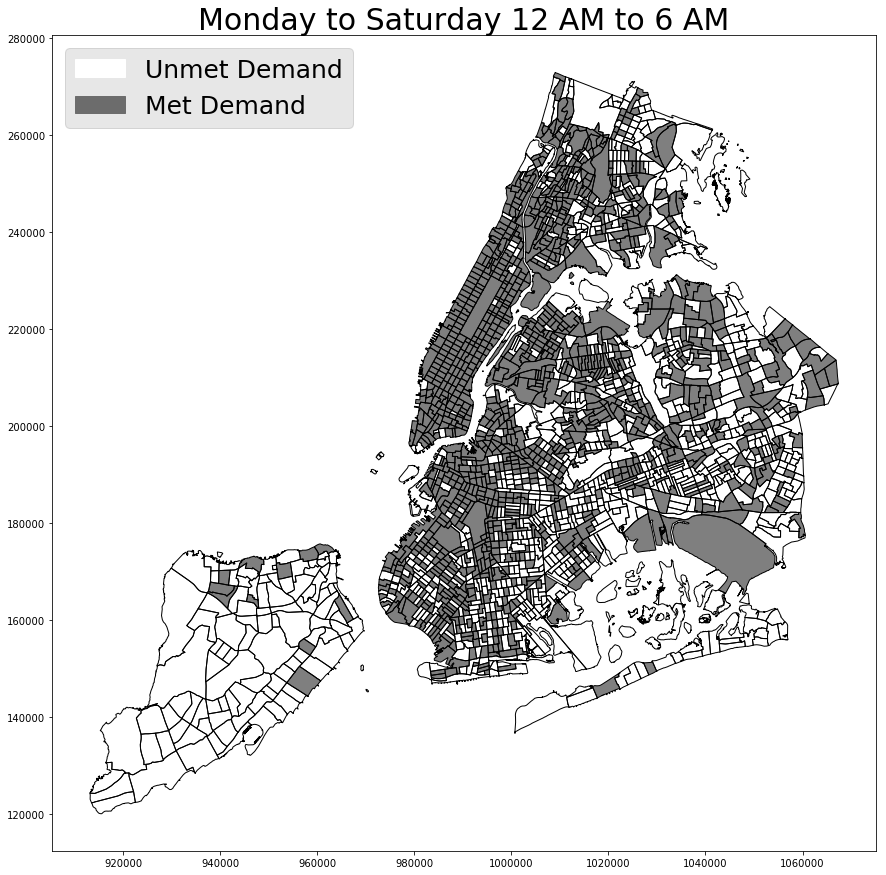

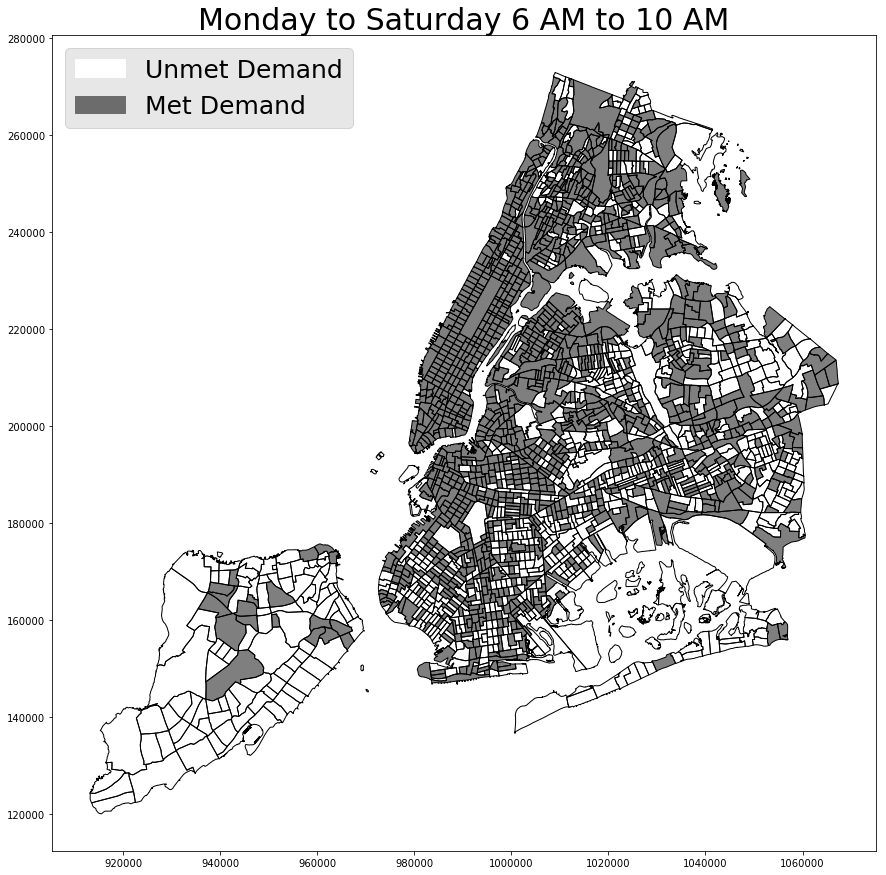

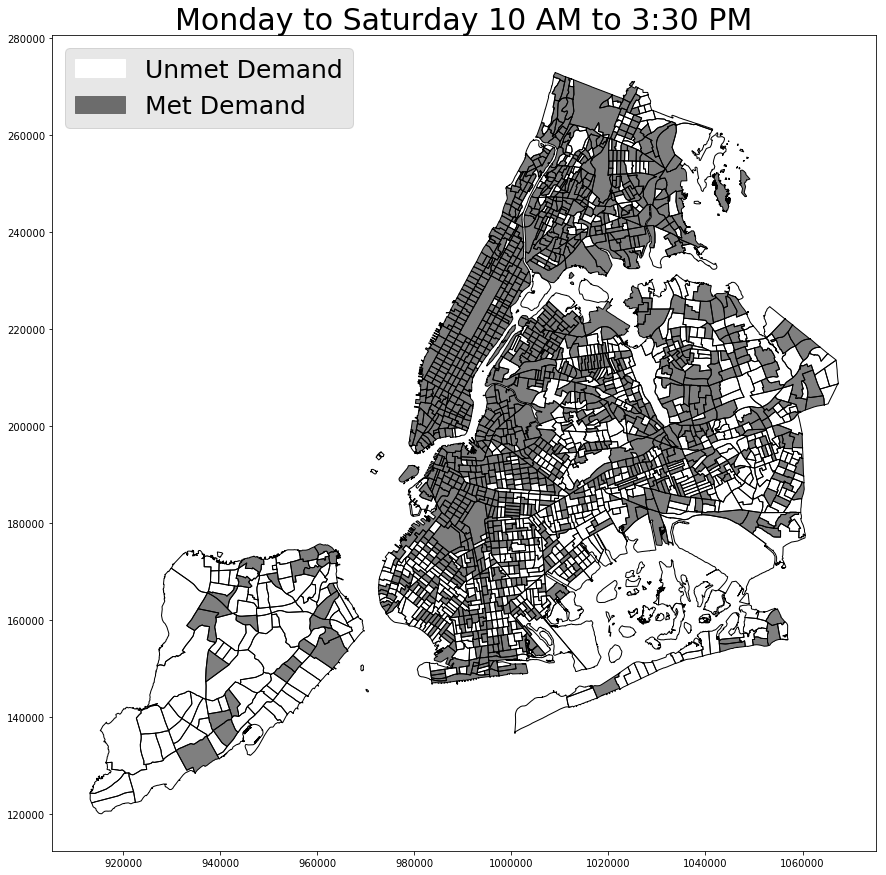

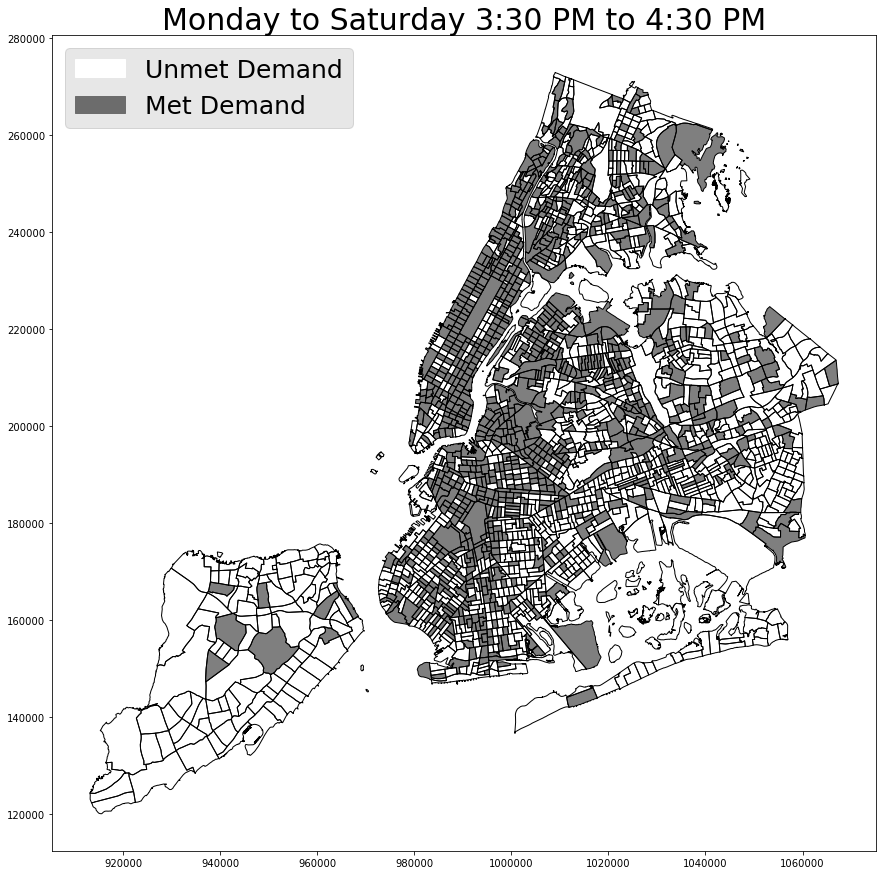

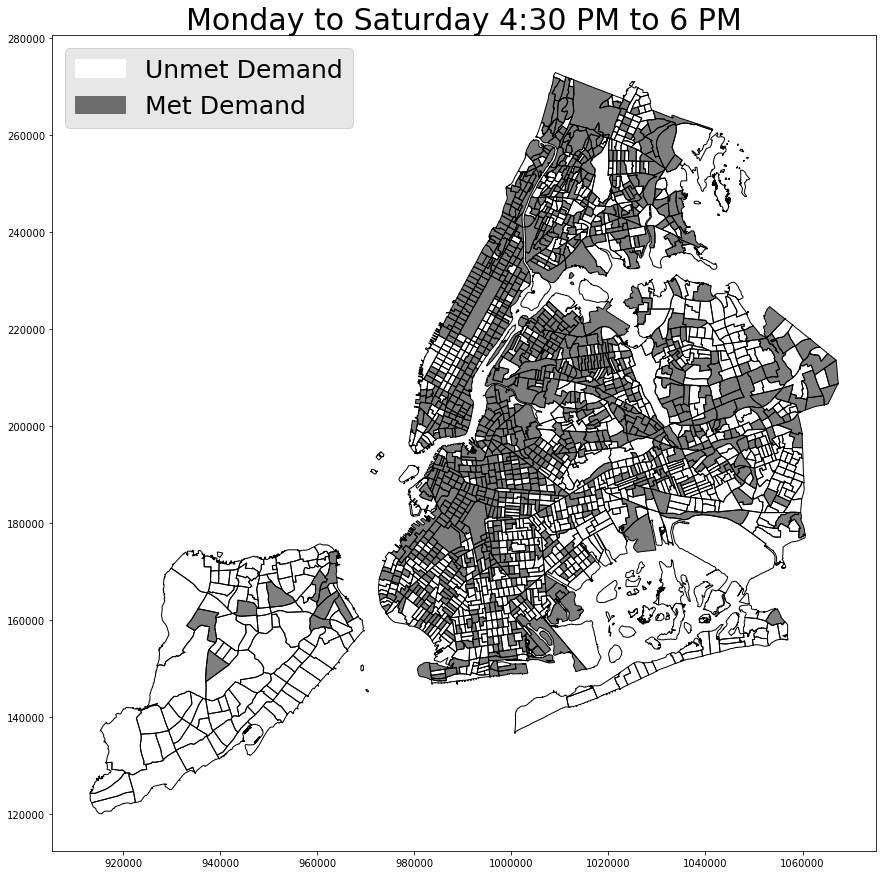

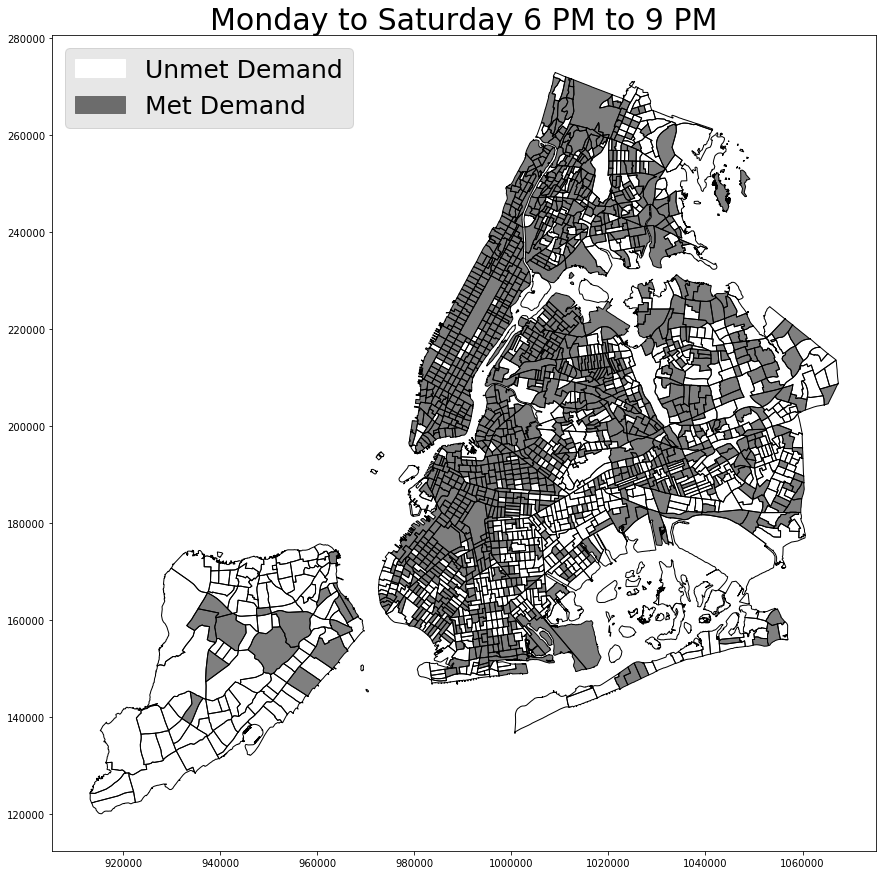

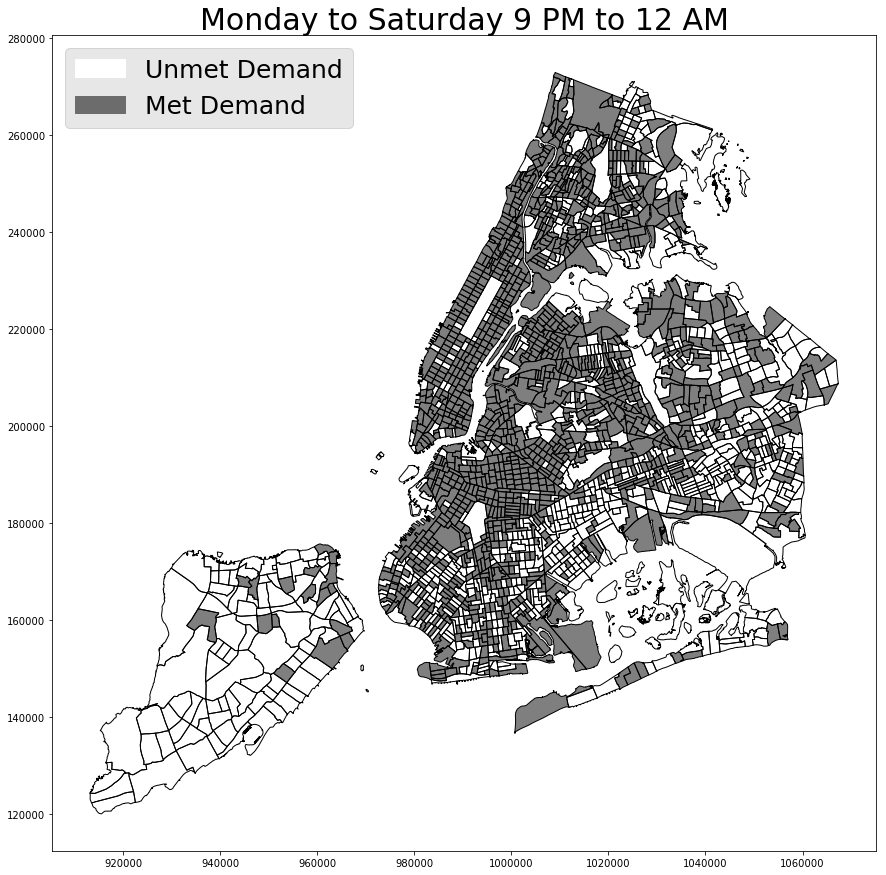

In [31]:
# Weekdays
wd = map(plot_choropleth, geo_week, weekday_names)

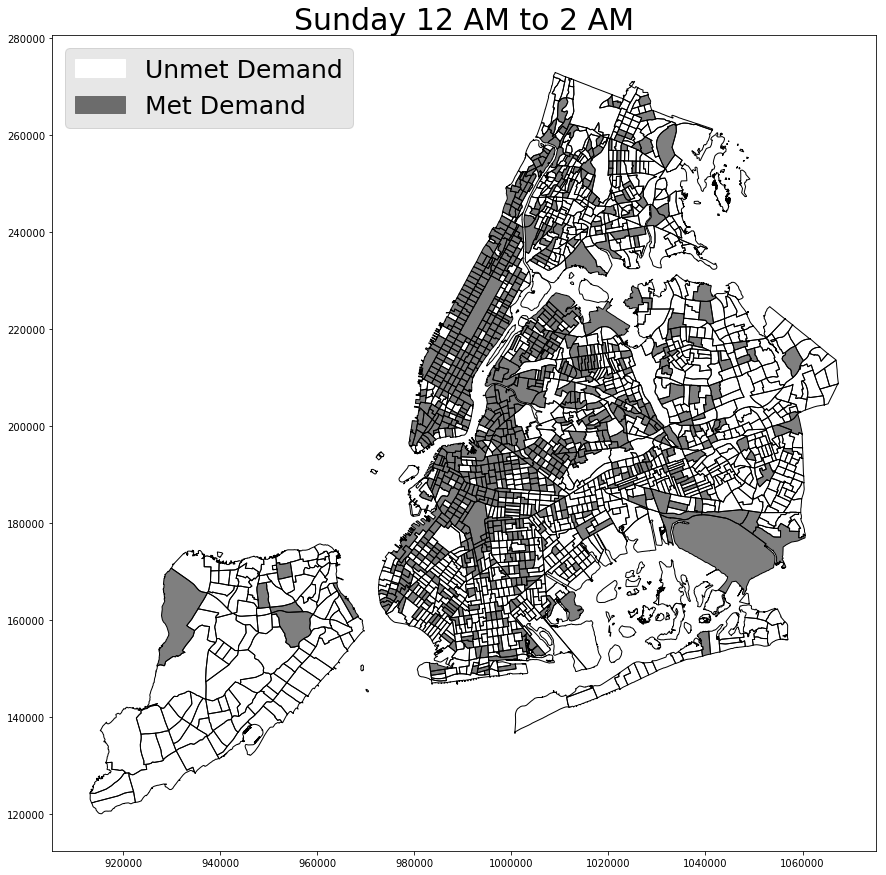

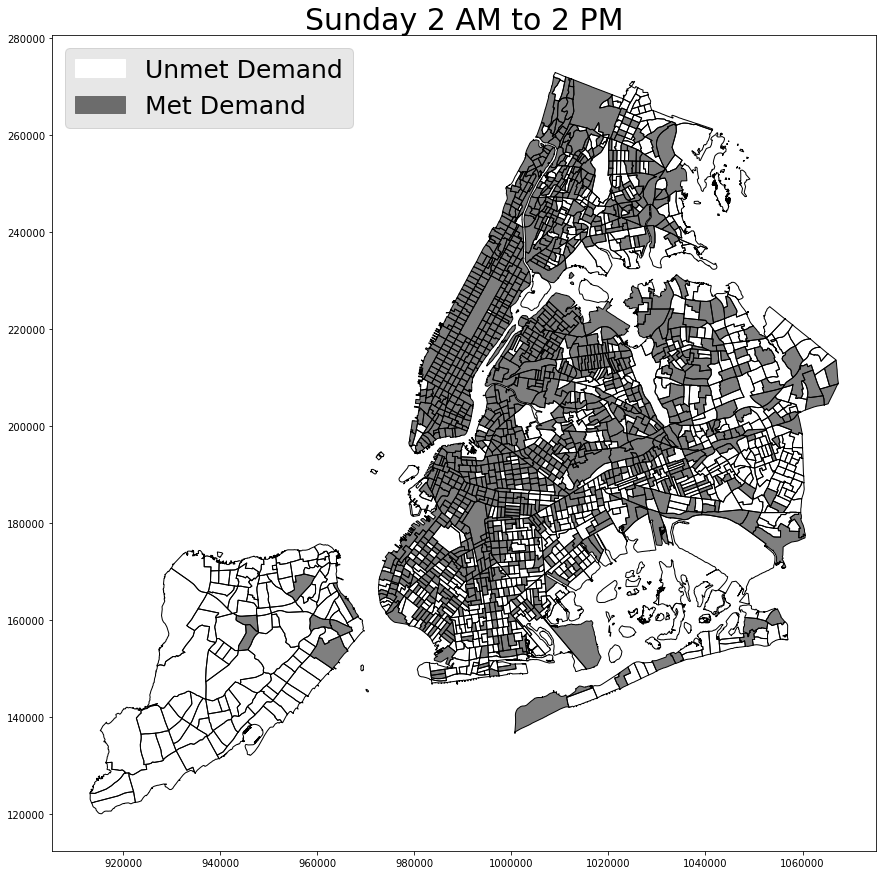

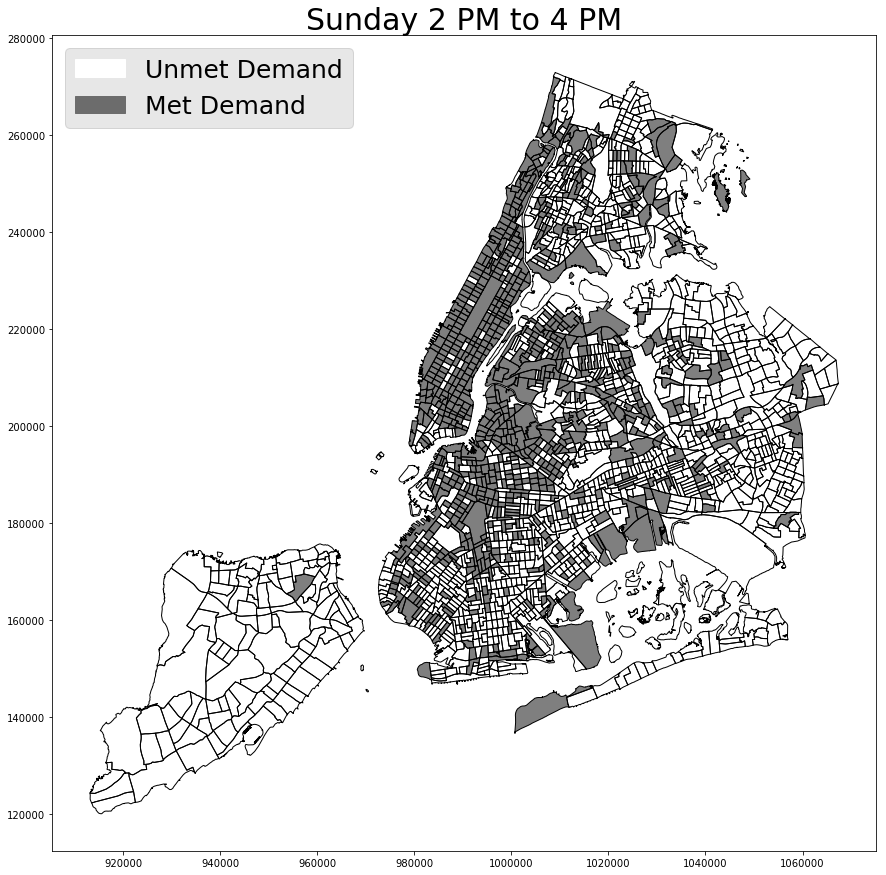

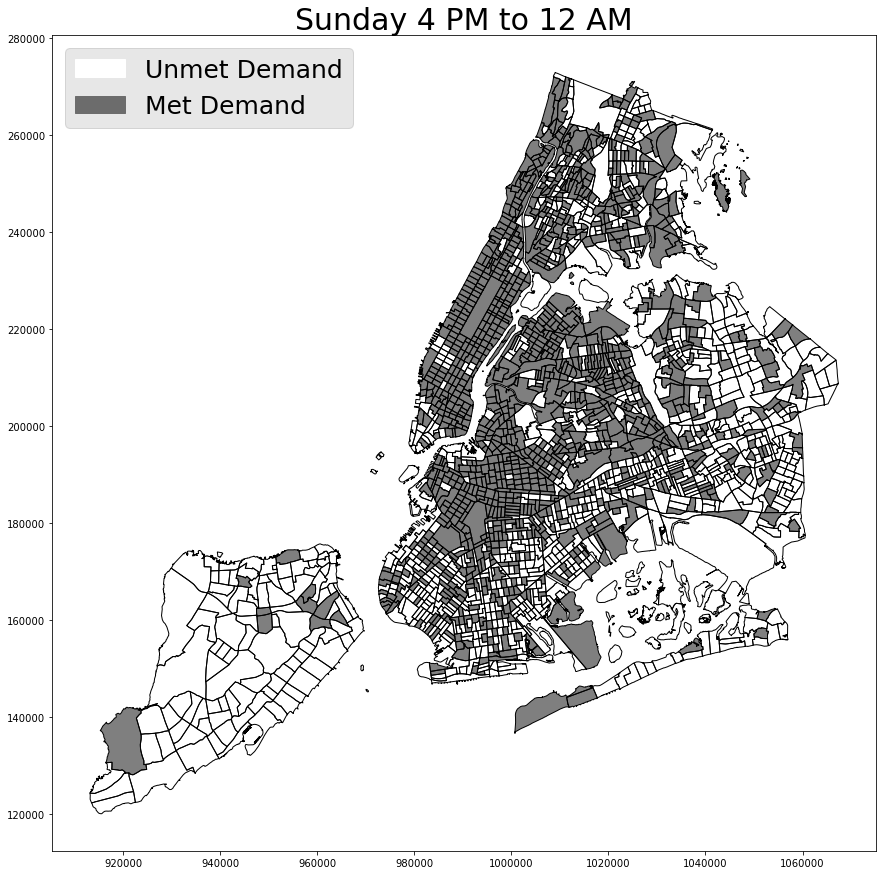

In [32]:
# Sundays
sd = map(plot_choropleth, geo_sund, sunday_names)

In [54]:
yellow_week = map(lambda name: pd.read_csv(name), name_week)
yellow_sund = map(lambda name: pd.read_csv(name), name_sund)
uber_week = map(lambda name: pd.read_csv('uber_'+name), name_week)
uber_sund = map(lambda name: pd.read_csv('uber_'+name), name_sund)

In [59]:
ycols = yellow_week[0].columns[1:-2]
ucols = uber_week[0].columns[1:-2]
yellow_week = map(lambda x: x[ycols], yellow_week)
yellow_sund = map(lambda x: x[ycols], yellow_sund)
uber_week = map(lambda x: x[ucols], uber_week)
uber_sund = map(lambda x: x[ucols], uber_sund)

In [66]:
def set_colnames(df):
    df.columns = [['BoroCT2010', '4', '5', '6', '7', '8', '9']]
    return df

yellow_week = map(set_colnames, yellow_week)
yellow_sund = map(set_colnames, yellow_sund)
uber_week = map(set_colnames, uber_week)
uber_sund = map(set_colnames, uber_sund)

In [76]:
#a = yellow_week[0].merge()
yellow = pd.concat(yellow_week+yellow_sund)
uberr = pd.concat(uber_week+uber_sund)

In [77]:
print len(yellow), sum(map(lambda x: len(x), yellow_week))+sum(map(lambda x: len(x), yellow_sund))
print len(uberr), sum(map(lambda x: len(x), uber_week))+sum(map(lambda x: len(x), uber_sund))

22716 22716
20975 20975


In [82]:
grouped = yellow.groupby(['BoroCT2010'], as_index=False)
yellow = grouped.agg(np.sum)
grouped = uberr.groupby(['BoroCT2010'], as_index=False)
uberr = grouped.agg(np.sum)

In [83]:
yellow.head(3), uberr.head(3)

(   BoroCT2010      4       5      6      7      8      9
 0           0  507.0   517.0  472.0  494.0  511.0  481.0
 1     1000100    0.0     2.0    0.0    0.0    0.0    0.0
 2     1000201  794.0  2072.0  747.0  912.0  751.0  893.0,
    BoroCT2010      4      5      6      7      8      9
 0     1000201  309.0  328.0  196.0  301.0  196.0  482.0
 1     1000202  232.0  260.0  174.0  328.0  266.0  411.0
 2     1000500    0.0    1.0    1.0    1.0    0.0    1.0)

In [90]:
def linear_fit(df, field):
    df[field] = zip(df['4'], df['5'], df['6'], df['7'], df['8'], df['9'])
    df[field] = df[field].apply(lambda x: np.polyfit(range(6), x, 1)[0])
    return df

In [95]:
yellow = linear_fit(yellow, 'yellow')
uberr  = linear_fit(uberr, 'uber')

In [101]:
yellow = yellow[['BoroCT2010', 'yellow']]
uberr = uberr[['BoroCT2010', 'uber']]

In [102]:
merged = yellow.merge(uberr, how = 'outer')

In [104]:
merged = merged.fillna(value = 0)

In [114]:
geo_df = merged.merge(ctracts, how = 'outer')

In [116]:
geo_df = geo_df.fillna(value = 0)

In [119]:
geo_df = geo_df[geo_df['BoroCT2010']<>0.0]

In [125]:
def process_slopes(dataframe_):
    def compare(record):
        if record[0]<=0:
            return 0
        if record[1]<=0.01:
            return record[1]
        return record[0]/record[1]
    
    dataframe_['zipped'] = zip(dataframe_['uber'], dataframe_['yellow'])
    dataframe_['ratio'] = dataframe_['zipped'].apply(compare)
    return dataframe_

In [126]:
geo_df = process_slopes(geo_df)

In [128]:
geo_df = GeoDataFrame(geo_df, crs = {'init': 'EPSG:2263'}, geometry = geo_df['geometry'])

In [131]:
geo_df  = get_labels(geo_df)

In [134]:
# Pickups choropleth map
def plot_choropleth(df, title):
    fieldname = 'label'

    cmap = matplotlib.cm.get_cmap('Greys')

    plot1 = df.plot(column=fieldname, cmap='Greys', scheme = 'Quantiles', legend = True, k = 5, figsize = (15, 15))
    a = np.array([[np.min(df[fieldname]), np.max(df[fieldname])]])

    Met_Demand = mpatches.Patch(color=cmap(0.65), label='Met Demand')
    Unmet_Demand = mpatches.Patch(color='white', label='Unmet Demand')
    legend = plt.legend(handles=[Unmet_Demand, Met_Demand], loc=2, fontsize = 25)
    frame = legend.get_frame()
    frame.set_facecolor(cmap(0.2))
    plt.title(title, fontsize = 30)

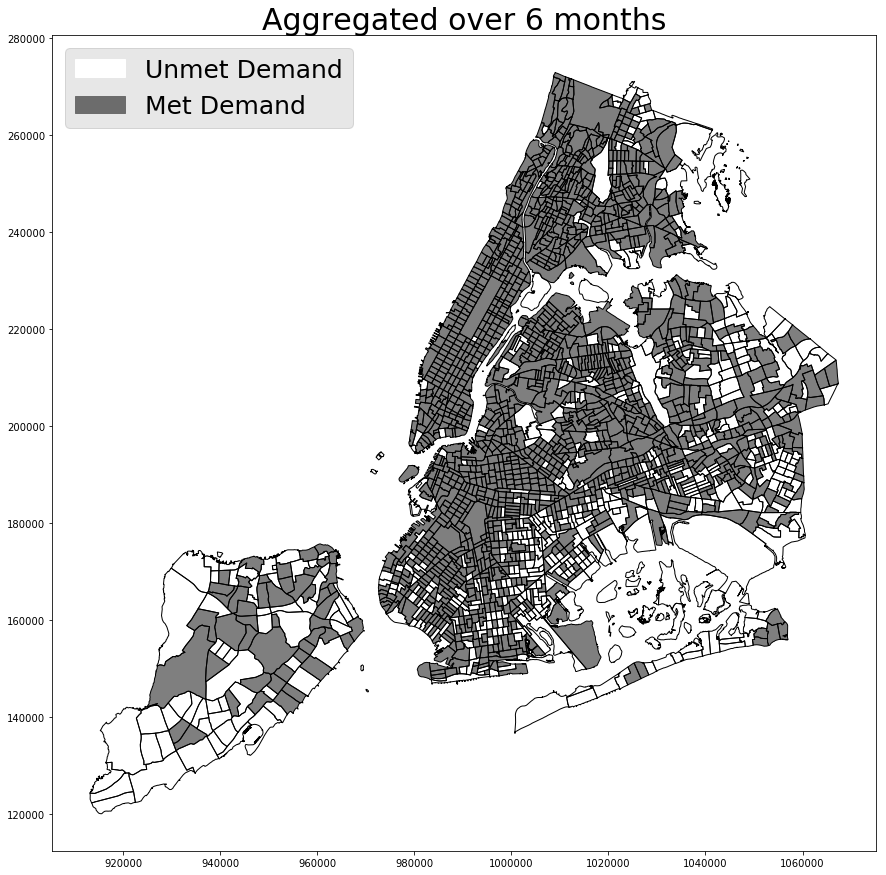

In [135]:
pltt = plot_choropleth(geo_df, 'Aggregated over 6 months')

In [138]:
geo_df = geo_df[['BoroCT2010', 'yellow', 'uber', 'geometry']]

In [140]:
geo_df.to_csv('aggregated_6months.csv')